In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, gaussian_vel_reconstruction, calc_ow, normalize_matrix


In [2]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})

df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
df_sadcp = df_sadcp[df_sadcp['Lon'] <= 155]
df_sadcp= df_sadcp.reset_index().drop(columns=['index'])

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_717,v_727,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043875,0.044484,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.056159,0.075346,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,0.056037,0.093465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.084378,0.079553,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.093274,0.105179,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### ESPRA App. 1

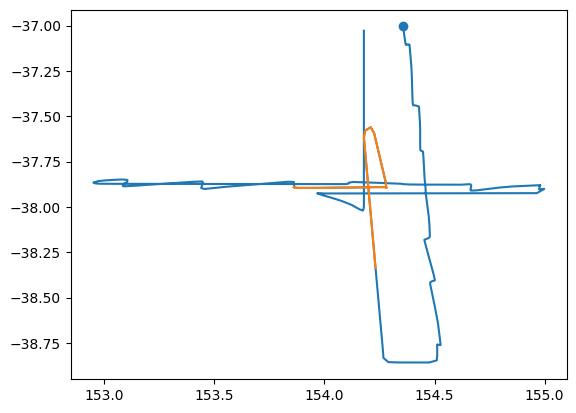

In [3]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t1 = pd.Timestamp('2023-10-19 5:00:00')
days1 = .3
df1 = df_sadcp[(df_sadcp.Time >= t1 - pd.Timedelta(days=days1)) & (df_sadcp.Time <= t1 + pd.Timedelta(days=days1))].copy()
plt.plot(df1.Lon, df1.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])


In [4]:
df_results1 = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
us = [col for col in df1.columns if col.startswith('u_')]
vs = [col for col in df1.columns if col.startswith('v_')]
for (u_idx, v_idx) in zip(us, vs):
    ui, vi = df1[u_idx], df1[v_idx]
    xi, yi = df1.Lon, df1.Lat

    df_clean1 = pd.DataFrame({'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi})
    df_clean1 = df_clean1.dropna()

    if len(df_clean1):
        xc, yc, w, Q, Rc, psi0 = espra(df_clean1.xi, df_clean1.yi, df_clean1.ui, df_clean1.vi, Rc_max=50)
        df_results1.loc[len(df_results1)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'Depth': int(u_idx[2:])}
        

In [5]:
# find & sort your u_/v_ columns by the number after the underscore
import re

def depth_key(col):
    # assumes columns like 'u_10', 'v_219', etc.
    return int(re.split(r'u_|v_', col)[1])

u_cols = sorted([c for c in df1.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df1.columns if c.startswith('v_')], key=depth_key)

results = []
for u_col, v_col in zip(u_cols, v_cols):
    depth = depth_key(u_col)
    # drop rows if any of Lon/Lat/u/v is NaN
    df_clean = df1[['Lon', 'Lat', u_col, v_col]].dropna()
    if df_clean.empty:
        continue

    xc, yc, w, Q, Rc, psi0 = espra(
        df_clean['Lon'],
        df_clean['Lat'],
        df_clean[u_col],
        df_clean[v_col],
        Rc_max=50
    )
    results.append({
        'xc':    xc,
        'yc':    yc,
        'w':     w,
        'Q':     Q,
        'Rc':    Rc,
        'psi0':  psi0,
        'Depth': depth
    })

# build your DataFrame once
df_results1 = pd.DataFrame(results, columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
df_results1 = df_results1[df_results1['Depth'] <= 680]
df_results1 = df_results1.reset_index().drop(columns=['index'])


In [6]:
df_results1


,xc,yc,w,Q,Rc,psi0,Depth
0,154.345586,-37.923586,-3.501609,"[[-0.8469194101978027, -0.02526943043219398], ...",0.828858,0.748596,37
1,154.351620,-37.917914,-3.433401,"[[-0.8220455325771786, -0.012342772674778676],...",0.861844,0.803668,47
2,154.362663,-37.909006,-3.333933,"[[-0.7856933022073451, 0.0056177403002952864],...",0.866946,0.812204,57
3,154.370480,-37.901684,-3.182035,"[[-0.7378411718025264, 0.014601841387943008], ...",0.860610,0.799515,67
4,154.384322,-37.891320,-2.978204,"[[-0.6643711220315979, 0.024374940776905715], ...",0.824086,0.736113,77
...,...,...,...,...,...,...,...
60,154.392069,-37.897263,-2.294467,"[[-0.4334472721290313, -0.018776200431432], [-...",0.926111,0.904308,637
61,154.399649,-37.894515,-2.286480,"[[-0.4247142692417963, -0.0016952917171243458]...",0.912583,0.879919,647
62,154.406119,-37.889401,-2.250404,"[[-0.4120245348926238, 0.009864800589830948], ...",0.942723,0.935649,657
63,154.404989,-37.875311,-2.290018,"[[-0.43022589242600207, 0.038610288480247515],...",0.906766,0.873313,667


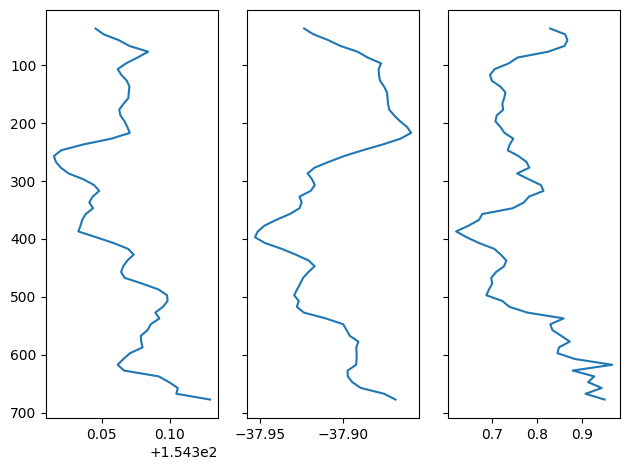

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True)
mask = df_results1.Depth <= 680
axs[0].plot(df_results1.xc[mask], df_results1.Depth[mask])
axs[0].invert_yaxis()
axs[1].plot(df_results1.yc[mask], df_results1.Depth[mask])
axs[2].plot(df_results1.Rc[mask], df_results1.Depth[mask])
plt.tight_layout()

#### ESPRA App. 2

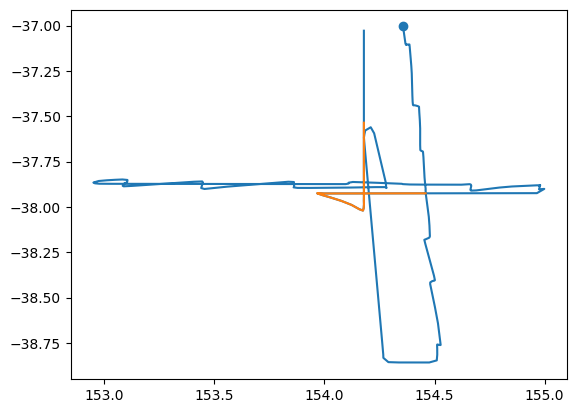

In [8]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t2 = pd.Timestamp('2023-10-21 13:30:00')
days2 = .2
df2 = df_sadcp[(df_sadcp.Time >= t2 - pd.Timedelta(days=days2)) & (df_sadcp.Time <= t2 + pd.Timedelta(days=days2))].copy()
plt.plot(df2.Lon, df2.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])


In [9]:
u_cols = sorted([c for c in df2.columns if c.startswith('u_')], key=depth_key)
v_cols = sorted([c for c in df2.columns if c.startswith('v_')], key=depth_key)

results = []
for u_col, v_col in zip(u_cols, v_cols):
    depth = depth_key(u_col)
    # drop rows if any of Lon/Lat/u/v is NaN
    df_clean = df2[['Lon', 'Lat', u_col, v_col]].dropna()
    if df_clean.empty:
        continue

    xc, yc, w, Q, Rc, psi0 = espra(
        df_clean['Lon'],
        df_clean['Lat'],
        df_clean[u_col],
        df_clean[v_col],
        Rc_max=50
    )
    results.append({
        'xc':    xc,
        'yc':    yc,
        'w':     w,
        'Q':     Q,
        'Rc':    Rc,
        'psi0':  psi0,
        'Depth': depth
    })

# build your DataFrame once
df_results2 = pd.DataFrame(results, columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'Depth'])
df_results2 = df_results2[df_results2['Depth'] <= 680]
df_results2 = df_results2.reset_index().drop(columns=['index'])


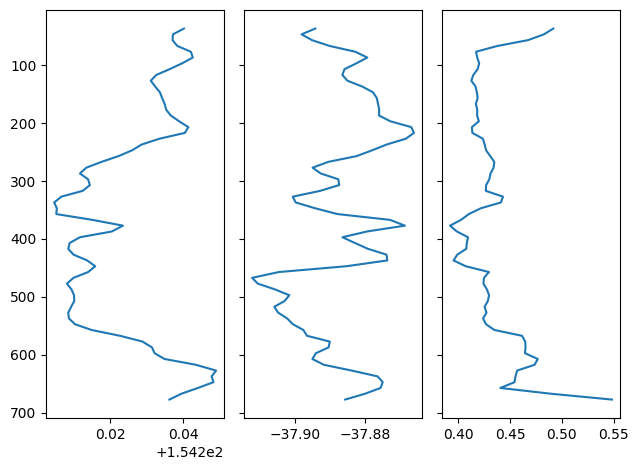

In [10]:
fig, axs = plt.subplots(1, 3, sharey=True)
mask = df_results2.Depth <= 680
axs[0].plot(df_results2.xc[mask], df_results2.Depth[mask])
axs[0].invert_yaxis()
axs[1].plot(df_results2.yc[mask], df_results2.Depth[mask])
axs[2].plot(df_results2.Rc[mask], df_results2.Depth[mask])
plt.tight_layout()


In [11]:
df_results2

,xc,yc,w,Q,Rc,psi0,Depth
0,154.240249,-37.894239,-4.301889,"[[-1.134923000444562, 0.17547632302916122], [0...",0.491773,0.283579,37
1,154.237228,-37.898178,-4.294657,"[[-1.1426254141724068, 0.16596942534175635], [...",0.482707,0.275035,47
2,154.237128,-37.895192,-4.319611,"[[-1.157440512260209, 0.1776404150172247], [0....",0.467305,0.260544,57
3,154.238413,-37.890131,-4.293703,"[[-1.168092513489459, 0.1987740937891878], [0....",0.437901,0.234008,67
4,154.242161,-37.882772,-4.153022,"[[-1.1432483962432276, 0.21649482901082223], [...",0.417248,0.215028,77
...,...,...,...,...,...,...,...
60,154.247863,-37.876367,-2.888408,"[[-0.7294166155874338, 0.18456714459809775], [...",0.455239,0.236157,637
61,154.248361,-37.874883,-2.755177,"[[-0.7042877891652537, 0.1904305361986681], [0...",0.454338,0.233765,647
62,154.244093,-37.875498,-2.701242,"[[-0.6994588252884444, 0.18460430454897742], [...",0.440659,0.220701,657
63,154.239521,-37.879988,-2.599451,"[[-0.6962439597446345, 0.1652947907199163], [0...",0.489744,0.264735,667


#### Test App

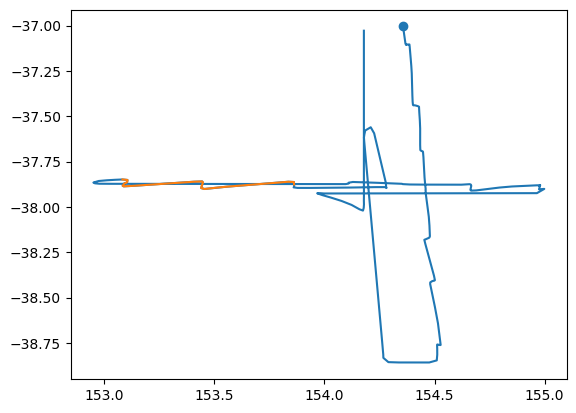

In [12]:
plt.plot(df_sadcp.Lon, df_sadcp.Lat)

t3 = pd.Timestamp('2023-10-19 18:00:00')
days3 = .2
df3 = df_sadcp[(df_sadcp.Time >= t3 - pd.Timedelta(days=days3)) & (df_sadcp.Time <= t3 + pd.Timedelta(days=days3))].copy()
plt.plot(df3.Lon, df3.Lat)
plt.scatter(df_sadcp.Lon.iloc[0], df_sadcp.Lat.iloc[0])


### Reconstruction

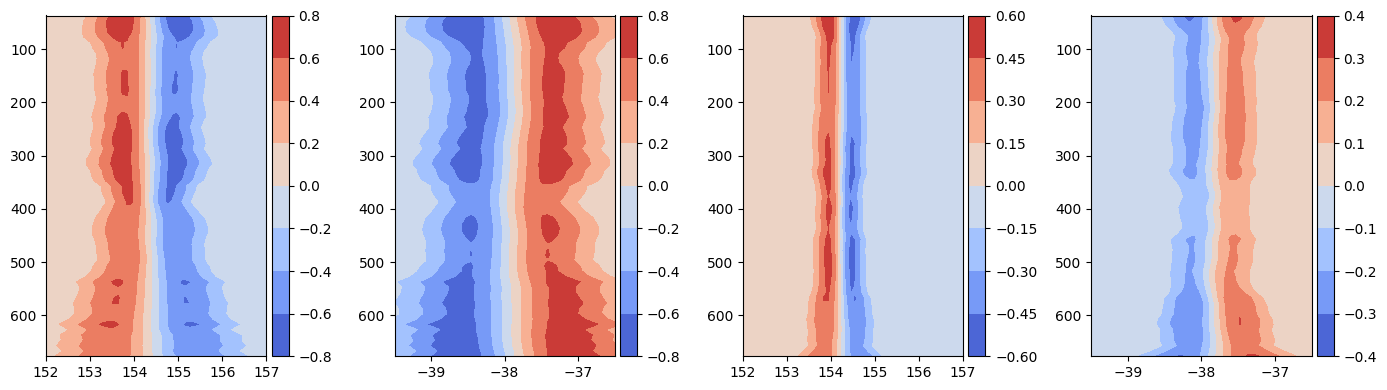

In [13]:
x, y = np.linspace(152, 157, 50), np.linspace(-39.5, -36.5, 50)
X, Y = np.meshgrid(x, y)
dx, dy = x[1]-x[0], y[1]-y[0]
dx_deg, dy_deg = dx * np.cos(np.deg2rad(np.mean(y))) * 111.32, dy * np.cos(np.deg2rad(np.mean(y))) * 111.32

U1 = np.zeros((X.shape[0], X.shape[1], len(df_results1)))
V1 = np.zeros((X.shape[0], X.shape[1], len(df_results1)))
OW1 = np.zeros((X.shape[0], X.shape[1], len(df_results1)))
for k in range(len(df_results1)):
    data = df_results1.iloc[k]
    xc, yc, Q11, Q12, Q22, Rc, psi0 = data.xc, data.yc, data.Q[0,0], data.Q[1,0], data.Q[1,1], data.Rc, data.psi0
    u1, v1, *_ = gaussian_vel_reconstruction(xc, yc, Q11, Q12, Q22, Rc, psi0, X, Y)
    U1[:,:,k] = u1
    V1[:,:,k] = v1
    OW1[:,:,k] = calc_ow(u1.T, v1.T, dy_deg, dx_deg).T
OW1 = normalize_matrix(OW1)

U2 = np.zeros((X.shape[0], X.shape[1], len(df_results2)))
V2 = np.zeros((X.shape[0], X.shape[1], len(df_results2)))
OW2 = np.zeros((X.shape[0], X.shape[1], len(df_results2)))
for k in range(len(df_results2)):
    data = df_results2.iloc[k]
    xc, yc, Q11, Q12, Q22, Rc, psi0 = data.xc, data.yc, data.Q[0,0], data.Q[1,0], data.Q[1,1], data.Rc, data.psi0
    u2, v2, *_ = gaussian_vel_reconstruction(xc, yc, Q11, Q12, Q22, Rc, psi0, X, Y)
    U2[:,:,k] = u2
    V2[:,:,k] = v2
    OW2[:,:,k] = calc_ow(u2.T, v2.T, dy_deg, dx_deg).T
OW2 = normalize_matrix(OW2)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
# draw and store each contourf
cf0 = axs[0].contourf(x, df_results1.Depth, V1[V1.shape[0]//2, :, :].T, cmap='coolwarm')
axs[0].invert_yaxis()

cf1 = axs[1].contourf(y, df_results1.Depth, U1[:, U1.shape[1]//2, :].T, cmap='coolwarm')
axs[1].invert_yaxis()

cf2 = axs[2].contourf(x, df_results2.Depth, V2[V2.shape[0]//2, :, :].T, cmap='coolwarm')
axs[2].invert_yaxis()

cf3 = axs[3].contourf(y, df_results2.Depth, U2[:, U2.shape[1]//2, :].T, cmap='coolwarm')
axs[3].invert_yaxis()

# attach one colourbar per axis
for ax, cf in zip(axs, (cf0, cf1, cf2, cf3)):
    fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()


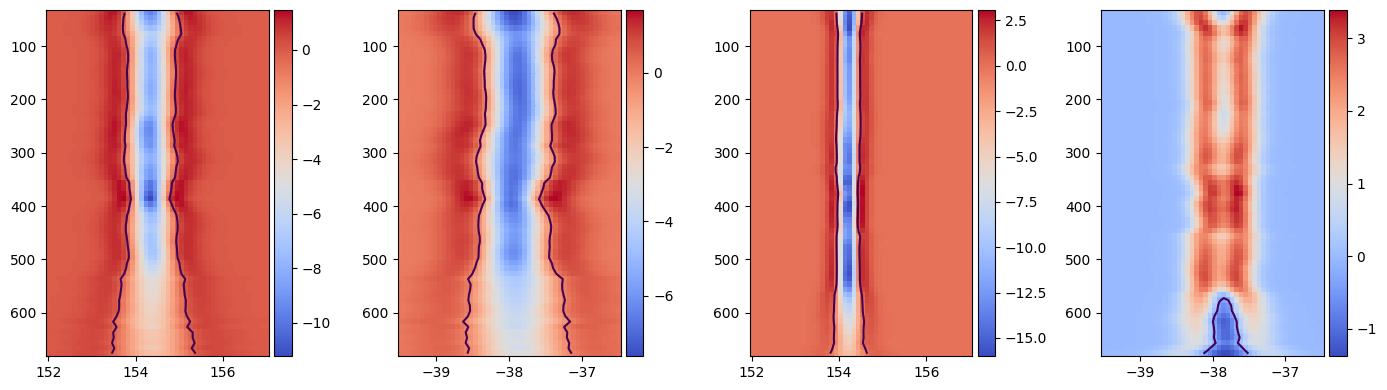

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(14, 4))
# draw and store each contourf
cf0 = axs[0].pcolor(x, df_results1.Depth, OW1[OW1.shape[0]//2, :, :].T, cmap='coolwarm')
axs[0].contour(x, df_results1.Depth, OW1[OW1.shape[0]//2, :, :].T, levels=[-.2])
axs[0].invert_yaxis()

cf1 = axs[1].pcolor(y, df_results1.Depth, OW1[:, OW1.shape[1]//2, :].T, cmap='coolwarm')
axs[1].contour(y, df_results1.Depth, OW1[:, OW1.shape[1]//2, :].T, levels=[-.2])
axs[1].invert_yaxis()

cf2 = axs[2].pcolor(x, df_results2.Depth, OW2[OW2.shape[0]//2, :, :].T, cmap='coolwarm')
axs[2].contour(x, df_results2.Depth, OW2[OW2.shape[0]//2, :, :].T, levels=[-.2])
axs[2].invert_yaxis()

cf3 = axs[3].pcolor(y, df_results2.Depth, OW2[:, OW2.shape[1]//2, :].T, cmap='coolwarm')
axs[3].contour(y, df_results2.Depth, OW2[:, OW2.shape[1]//2, :].T, levels=[-.2])
axs[3].invert_yaxis()

# attach one colourbar per axis
for ax, cf in zip(axs, (cf0, cf1, cf2, cf3)):
    fig.colorbar(cf, ax=ax, orientation='vertical', pad=0.02)

plt.tight_layout()
plt.show()


### Case 1 Analysis

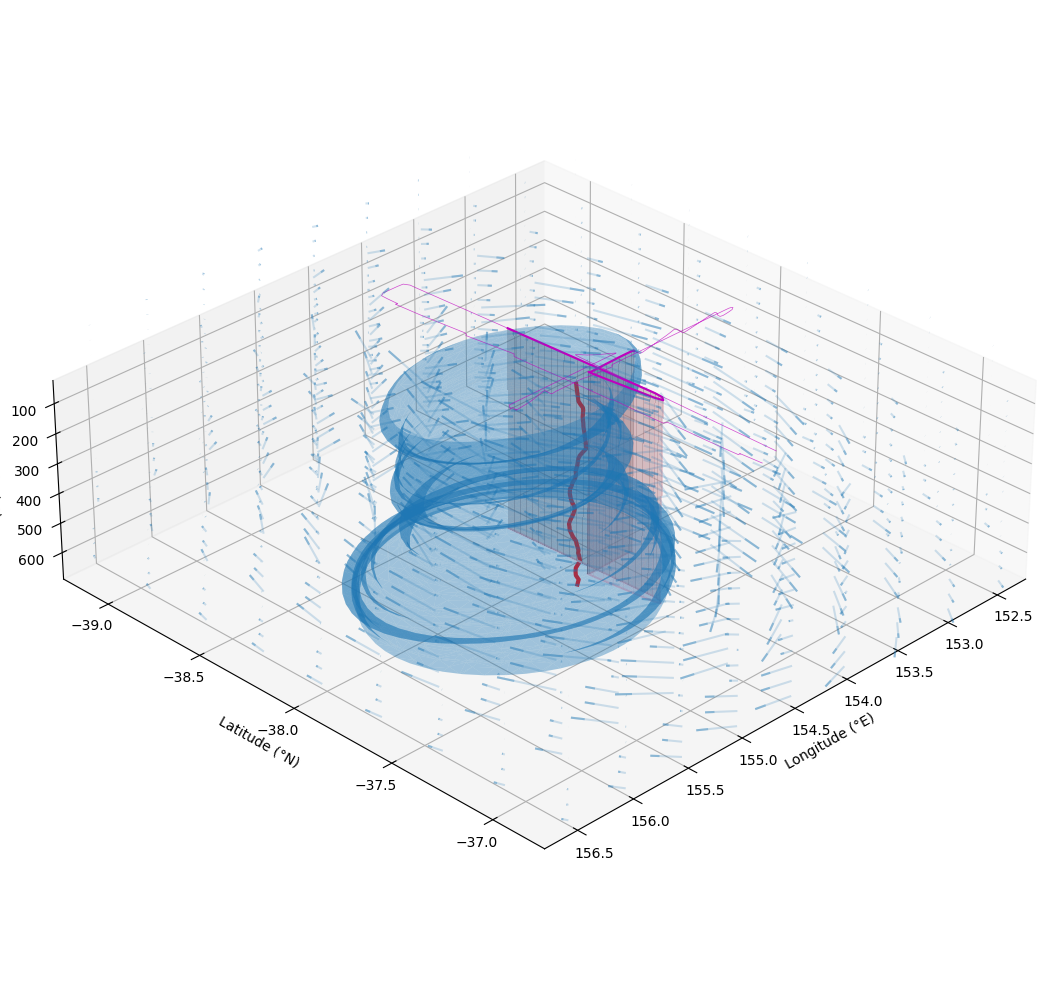

In [15]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# volume.shape == (nz, ny, nx); X.shape == (ny, nx); Y.shape == (ny, nx); z.shape == (nz,)

z = df_results1.Depth.values
dz = z[1] - z[0]

verts, faces, normals, values = measure.marching_cubes(
    OW1, level=-0.2, spacing=(dx, dy, dz)
)
# shift into your real-world coordinates
verts[:,0] += X.min()
verts[:,1] += Y.min()
verts[:,2] += z.min()

fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(projection='3d')
mesh = Poly3DCollection(verts[faces], alpha=0.4, edgecolor='none')
ax.add_collection3d(mesh)
buff = .3

ax.set_xlim(X.min()+buff, X.max()-buff)
ax.set_ylim(Y.min()+buff, Y.max()-buff)
ax.set_zlim(z.min(), z.max())

ax.set_box_aspect([3, 3, 1])

ax.view_init(elev=30, azim=45)

ax.plot(df_results1.xc, df_results1.yc, df_results1.Depth, color='r', linewidth=3)
z_spac = 5
scale = .5
for k in range(0, len(df_results1), z_spac):
    data = df_results1.iloc[k]
    spac = 5
    
    ax.quiver(X[::spac, ::spac], Y[::spac, ::spac], data.Depth * np.ones_like(X[::spac, ::spac]),
              U1[::spac, ::spac, k], V1[::spac, ::spac, k], np.zeros_like(U1[::spac, ::spac, k]), alpha=.2, length=scale)

ax.plot(df_sadcp.Lon, df_sadcp.Lat, [0]*len(df_sadcp), 'm', zorder=10, linewidth=.5, alpha=.7)
ax.plot(df1.Lon, df1.Lat, [0]*len(df1), 'm', zorder=10)

X_track = df1.Lon
Y_track = df1.Lat

Z0_track = np.zeros_like(X_track)
Z1_track = np.max(df_results1.Depth) * np.ones_like(X_track)

X2_track = np.vstack([X_track, X_track])
Y2_track = np.vstack([Y_track, Y_track])
Z2_track = np.vstack([Z0_track, Z1_track])

ax.plot(   X_track,   Y_track,   Z0_track, color='pink')  # surface track
ax.plot(   X_track,   Y_track,   Z1_track, color='pink')  # bottom edge at 1000 m
ax.plot_surface(X2_track, Y2_track, Z2_track,
                color='pink',
                alpha=0.3,
                rstride=1, cstride=1,
                linewidth=0,
                antialiased=False)

ax.invert_zaxis()

ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
ax.set_zlabel('Depth (m)')
plt.tight_layout()
plt.show()
